In [1]:
from pathlib import Path
from PIL import Image
import numpy as np

In [2]:
# _0 - tryon
# _1 - garment
#
datadir = Path('/mnt/datadrive/dress_code/upper_body/images')
dataddd = Path('/mnt/datadrive/dress_code/upper_body/label_maps/')

img_pairs = []
with open('/mnt/datadrive/dress_code/upper_body/train_pairs.txt', 'r') as fi:
    for line in fi.readlines():
        tryon, garment = line.strip().split('\t')
        tryon_fullpath = datadir / tryon
        garment_fullpath = datadir / garment
        img_idx = f'{garment_fullpath.name.split("_")[0]}_4.png'
        hp_fullpath = dataddd / img_idx
        img_pairs.append((tryon_fullpath, garment_fullpath, hp_fullpath))

len(img_pairs)

13563

In [107]:
# import cv2
# # /mnt/datadrive/dress_code/upper_body/label_maps/000000_4.png
# ii = cv2.imread('/mnt/datadrive/dress_code/upper_body/label_maps/000000_4.png')
# gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)

In [108]:
# np.unique(gray_image)

In [109]:
# gray_image[gray_image==15] = 0
# plt.imshow(gray_image)

In [3]:
import pickle 

import torch
from torch.utils.data import DataLoader, Dataset
import cv2
from pathlib import Path
from PIL import Image
import numpy as np
from clothing_segmentation import HumanParser
import pandas as pd

from torchvision import transforms as T


from controlnet_aux import OpenposeDetector
from controlnet_aux.open_pose import HWC3, resize_image
from diffusers.utils import load_image



class MyOpenPoseDetector(OpenposeDetector):
    
    def __call__(self, input_image, detect_resolution=512, include_hand=False, include_face=False):
       
        if not isinstance(input_image, np.ndarray):
            input_image = np.array(input_image, dtype=np.uint8)

        input_image = HWC3(input_image)
        input_image = resize_image(input_image, detect_resolution)

        poses = self.detect_poses(input_image, include_hand, include_face)
        xy=[]
        if len(poses)>0:
            for point in poses[0].body.keypoints:
                if point is not None:
                    xy.append([point.x, point.y])
                else:
                    xy.append([0, 0])
            return np.array(xy)
        else:
            return None
        

class SyntheticTryonDataset(Dataset):
    def __init__(self, image_size=(128, 128), pose_size=(18, 2), apply_transform=True):

        self.human_parser = HumanParser()
        self.transform = T.Compose([
            # T.Resize(image_size),
            # T.CenterCrop(image_size),
            T.ToTensor(),
        ])
        self.apply_transform = apply_transform
        # self.df = pd.read_csv('/home/roman/tryondiffusion_implementation/tryondiffusion_danny/all_imgs.csv')
        # self.df = self.df[~self.df['pose_is_none']]
        self.img_list = img_pairs
        # tryon, garment, person_hp


        # self.items_reverse_index = {}
        # self.items_reverse_index_poses = {}
        # for group_idx, group in self.df.groupby(by='item_idx'):
        #     self.items_reverse_index[group_idx] = group['fullpath'].values        
        #     self.items_reverse_index_poses[group_idx] = group['pose_512'].values        
        
        self.image_size = image_size
        # self.pose_size = pose_size
        self.openpose = MyOpenPoseDetector.from_pretrained("lllyasviel/ControlNet")

        
    def __len__(self):
        return len(self.img_list)
    
    def prepare_clothing_agnostic(self, img, hp_mask)-> np.array: 
        # classes_to_rm=[4,6] 
        classes_to_rm=[4]      
        # def get_clothing_agnostic(image, hp_mask, classes_to_rm=[4,6]):
        bg_color = (255,255,255)
        assert img.shape[:-1] == hp_mask.shape
        # cloths_to_rm_mask = np.zeros(hp_mask.shape)
        # for i in np.unique(res):
        #     if i in classes_to_rm:
        #         cloths_to_rm_mask[res==i] = 255
        cloths_to_rm_mask = np.isin(hp_mask, classes_to_rm)
        img[cloths_to_rm_mask!=0] = bg_color
        return img
        
    def prepare_segmented_garment(self, img, hp_mask)-> np.array:
        # classes_to_rm=[4,6] 
        classes_to_rm=[4]        
        bg_color = (255,255,255)
        assert img.shape[:-1] == hp_mask.shape
        # cloths_to_rm_mask = np.zeros(hp_mask.shape)
        # for i in np.unique(res):
        #     if i in classes_to_rm:
        #         cloths_to_rm_mask[res==i] = 255
        cloths_to_rm_mask = np.isin(hp_mask, classes_to_rm)
        img[cloths_to_rm_mask==0] = bg_color
        return img

    def __getitem__(self, idx):
        # if idx not in self.items_reverse_index:
            # return self.__getitem__(idx-1)    
        # items_images_list = self.items_reverse_index[idx]
        
        # items_images_list_poses = self.items_reverse_index_poses[idx]
        img_person, img_garment, person_hp = self.img_list[idx]
        img_person = str(img_person)
        img_garment = str(img_garment)
        person_hp = str(person_hp)

        # if True:
            # person_pose = items_images_list_poses[0]
            # person_pose = pickle.loads(items_images_list_poses[0])
            
            # garment_pose = items_images_list_poses[1]
            # garment_pose = pickle.loads(items_images_list_poses[1])
        
        # inputs from img1
        # noisy
        # clothing agnostic
        # person pose
        # img = img.resize((768, 768), Image.BICUBIC)
        
        person_image = Image.open(img_person).convert('RGB').resize((768, 768), Image.BICUBIC)
        op_img = load_image(img_person)
        person_pose = self.openpose(op_img)
        # print(person_image.size)
        # .resize(self.image_size, Image.BICUBIC)
        np_person_image = np.array(person_image)
        person_image_resized = person_image.resize(self.image_size, Image.BICUBIC)
        # person_image_hp = self.human_parser.forward_img(person_image).squeeze(0)

        person_image_hp = cv2.imread(person_hp)
        person_image_hp = cv2.resize(person_image_hp, (self.image_size)) 

        gray_image = cv2.cvtColor(person_image_hp, cv2.COLOR_BGR2GRAY)

        ca_image = np.array(person_image_resized).copy()
        ca_image[gray_image==15] = (255,255,255)
        

        # ca_image = self.prepare_clothing_agnostic(np_person_image, person_image_hp)
        
        # inputs from img2
        # garment pose
        # segmented garmend
        garment_image = Image.open(img_garment).convert('RGB').resize((768, 768), Image.BICUBIC)
        op_img = load_image(img_garment)
        garment_pose = self.openpose(op_img)
        # print(garment_image.size)
        # .resize(self.image_size, Image.BICUBIC)
        np_garment_image = np.array(garment_image)
        # garment_image_hp = self.human_parser.forward_img(garment_image).squeeze(0)
        
        # segmented_garment = self.prepare_segmented_garment(np_garment_image, garment_image_hp) 
        segmented_garment = np_garment_image
        
        # person_image = torch.randn(3, *self.image_size)
        # ca_image = torch.randn(3, *self.image_size)
        # garment_image = torch.randn(3, *self.image_size)
        # person_pose = torch.randn(*self.pose_size)
        # garment_pose = torch.randn(*self.pose_size)

        # sample = {
        #     "person_images": person_image,
        #     "ca_images": ca_image,
        #     "garment_images": garment_image,
        #     "person_poses": person_pose,
        #     "garment_poses": garment_pose,
        # }
        garment_pose = np.array(
            [[0.45507812, 0.        ],
            [0.45703125, 0.11789773],
            [0.34179688, 0.11789773],
            [0.31640625, 0.27130682],
            [0.3203125 , 0.40767045],
            [0.57226562, 0.11647727],
            [0.609375  , 0.26704545],
            [0.59375   , 0.40482955],
            [0.38671875, 0.41051136],
            [0.38671875, 0.61931818],
            [0.39648438, 0.79545455],
            [0.52734375, 0.41051136],
            [0.52734375, 0.61931818],
            [0.50390625, 0.79829545],
            [0.4296875 , 0.        ],
            [0.48046875, 0.        ],
            [0.40039062, 0.        ],
            [0.52148438, 0.        ]]
        )

        sample = {
            "person_images": person_image_resized,
            "ca_images": Image.fromarray(ca_image.astype('uint8')).resize(self.image_size, Image.BICUBIC),
            "garment_images": Image.fromarray(segmented_garment.astype('uint8')).resize(self.image_size, Image.BICUBIC),
            "person_poses": person_pose,
            "garment_poses": garment_pose,
        }
        
        if self.apply_transform:
            sample = {
                "person_images": self.transform(sample['person_images']),
                "ca_images": self.transform(sample['ca_images']),
                "garment_images": self.transform(sample['garment_images']),
                "person_poses": sample['person_poses'],
                "garment_poses": sample['garment_poses']
            }
        
        return sample

/home/roman/venv_tryondiffusion_implementation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/roman/venv_tryondiffusion_implementation/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [4]:
from pathlib import Path
import pandas as pd
from PIL import Image
from tqdm import tqdm

import sys
import torch

sys.path.append('/home/roman/tryondiffusion_implementation/tryondiffusion_danny/tryondiffusion')
# from tryondiffusion import TryOnImagen, TryOnImagenTrainer, get_unet_by_name, SyntheticTryonDataset, tryondiffusion_collate_fn


# TODO resize pose from 512 to 64


TRAIN_UNET_NUMBER = 1
BASE_UNET_IMAGE_SIZE = (128, 128)
SR_UNET_IMAGE_SIZE = (256, 256)
BATCH_SIZE = 2 
GRADIENT_ACCUMULATION_STEPS = 2
NUM_ITERATIONS = 100
TIMESTEPS = (1000, 1000)

dataset = SyntheticTryonDataset(image_size=SR_UNET_IMAGE_SIZE if TRAIN_UNET_NUMBER == 2 else BASE_UNET_IMAGE_SIZE)

In [5]:
for i in dataset:
    print(i)
    break

{'person_images': tensor([[[0.9569, 0.9569, 0.9569,  ..., 0.9569, 0.9569, 0.9569],
         [0.9569, 0.9569, 0.9569,  ..., 0.9569, 0.9569, 0.9569],
         [0.9569, 0.9569, 0.9569,  ..., 0.9569, 0.9569, 0.9569],
         ...,
         [0.9569, 0.9569, 0.9569,  ..., 0.9569, 0.9569, 0.9569],
         [0.9569, 0.9569, 0.9569,  ..., 0.9569, 0.9569, 0.9569],
         [0.9569, 0.9569, 0.9569,  ..., 0.9569, 0.9569, 0.9569]],

        [[0.9569, 0.9569, 0.9569,  ..., 0.9569, 0.9569, 0.9569],
         [0.9569, 0.9569, 0.9569,  ..., 0.9569, 0.9569, 0.9569],
         [0.9569, 0.9569, 0.9569,  ..., 0.9569, 0.9569, 0.9569],
         ...,
         [0.9569, 0.9569, 0.9569,  ..., 0.9569, 0.9569, 0.9569],
         [0.9569, 0.9569, 0.9569,  ..., 0.9569, 0.9569, 0.9569],
         [0.9569, 0.9569, 0.9569,  ..., 0.9569, 0.9569, 0.9569]],

        [[0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 

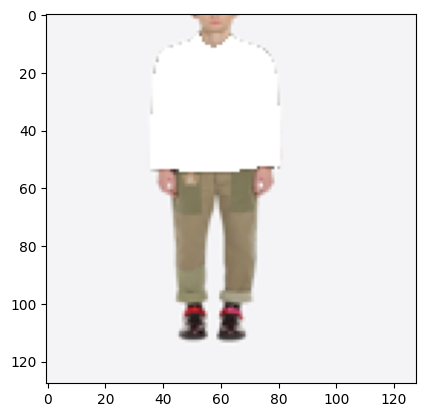

In [124]:
from matplotlib import pyplot  as plt


plt.imshow(i['ca_images'].permute(1,2,0))
plt.show()

In [6]:
prepared_ds_path = Path('/mnt/datadrive/dress_code/prepared_128/tensors')
prepared_ds_path.mkdir(parents=True, exist_ok=True)

from tqdm import trange
for idx in trange(0, len(dataset)):
    try:
        sample = dataset.__getitem__(idx)
        torch.save(sample, prepared_ds_path / f'{idx}.pt')
    except Exception as e:
        print(e)
        print(idx)


  0%|          | 0/13563 [00:00<?, ?it/s]

100%|██████████| 13563/13563 [3:15:29<00:00,  1.16it/s] 
